In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_path = './hour.csv'

rides = pd.read_csv(data_path)

rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
data[:24*10].plot(x='dteday', y='cnt')

NameError: name 'data' is not defined

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
    
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
test_data = data[-21*24:]
data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [7]:
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

print(val_targets.shape)

(1440, 3)


In [8]:
tf.reset_default_graph()

save_file = 'model.ckpt'
input_nodes = train_features.shape[1]
hidden_nodes = 15
output_nodes = 1
batch_size = 128
epochs = 1500
learning_rate = 0.01
display_rate = 10

x = tf.placeholder(tf.float32, shape = (None, input_nodes), name = 'x')
y = tf.placeholder(tf.float32, shape = (None, 1), name = 'y')

W1 = tf.Variable(tf.truncated_normal(shape = (input_nodes, hidden_nodes), stddev = 0.1), name = 'W1')
W2 = tf.Variable(tf.truncated_normal(shape = (hidden_nodes, output_nodes), stddev = 0.1), name = 'W2')

h1 = tf.nn.sigmoid(tf.matmul(x, W1))
output = tf.matmul(h1, W2)

cost = tf.reduce_mean(tf.square(tf.square(tf.subtract(output, y))), name = 'cost')
tf.summary.scalar('cost', cost)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_op = optimizer.minimize(cost)

init = tf.global_variables_initializer()

writer = tf.summary.FileWriter(logdir = './graphs')

summary = tf.summary.merge_all()

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    writer.add_graph(sess.graph)
    for i in range(epochs):
        batch = np.random.choice(train_features.index, size=128)
        X, Y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
        Y = np.reshape(Y, (Y.shape[0], 1))
        feed_dict = {x: X, y: Y}
        sess.run(train_op, feed_dict = feed_dict)
        if i % 10 == 0:
            c_cost, summary_result = sess.run([cost, summary] , feed_dict = feed_dict)
            writer.add_summary(summary_result, i)
            print("The current cost is {0}".format(c_cost))

    val_targets_reshaped = np.reshape(val_targets['cnt'], (val_targets['cnt'].shape[0], 1))
    validation_cost = sess.run(cost, feed_dict = {x: val_features, y: val_targets_reshaped})
    print("The validation cost is {0}".format(validation_cost))
    saver.save(sess, save_file)
    
writer.close()

/Users/arthur/anaconda/envs/tf-learn/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/arthur/anaconda/envs/tf-learn/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


The current cost is 4.232836723327637
The current cost is 3.1660141944885254
The current cost is 1.324908971786499
The current cost is 0.8702268004417419
The current cost is 2.2442119121551514
The current cost is 1.3207305669784546
The current cost is 1.1450375318527222
The current cost is 0.6935734748840332
The current cost is 0.7376589179039001
The current cost is 0.7121267318725586
The current cost is 0.4098300337791443
The current cost is 0.414983332157135
The current cost is 0.5440624952316284
The current cost is 0.417860746383667
The current cost is 0.5450947284698486
The current cost is 0.2252635359764099
The current cost is 0.14764630794525146
The current cost is 0.17713391780853271
The current cost is 0.3646458089351654
The current cost is 0.29338544607162476
The current cost is 0.2934754192829132
The current cost is 0.5292603373527527
The current cost is 0.3340500593185425
The current cost is 0.2415846884250641
The current cost is 0.28851518034935
The current cost is 0.253517

INFO:tensorflow:Restoring parameters from model.ckpt


/Users/arthur/anaconda/envs/tf-learn/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


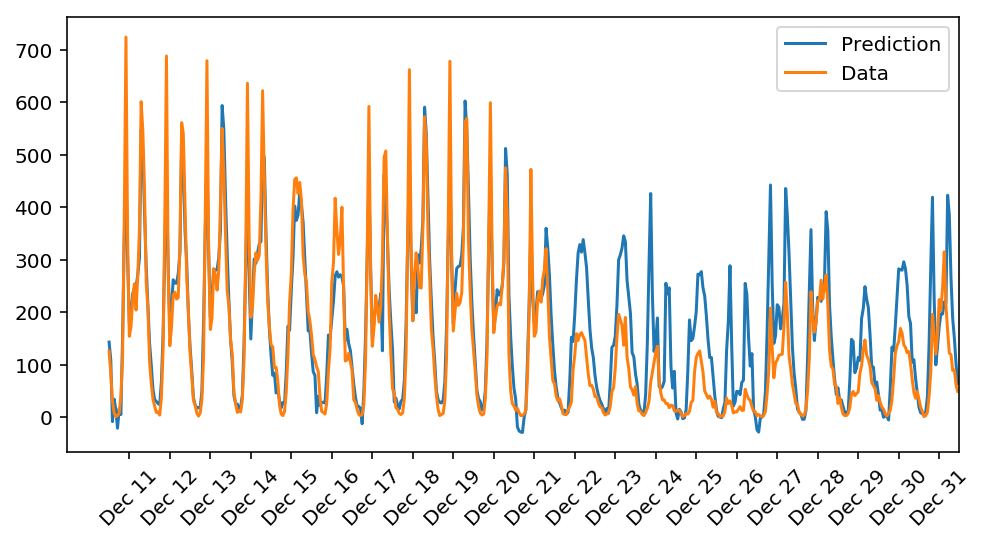

In [9]:
tf.reset_default_graph()

save_file = 'model.ckpt'
input_nodes = train_features.shape[1]
hidden_nodes = 15
output_nodes = 1

x = tf.placeholder(tf.float32, shape = (None, input_nodes), name = 'x')

W1 = tf.Variable(tf.truncated_normal(shape = (input_nodes, hidden_nodes), stddev = 0.1), name = 'W1')
W2 = tf.Variable(tf.truncated_normal(shape = (hidden_nodes, output_nodes), stddev = 0.1), name = 'W2')

h1 = tf.nn.sigmoid(tf.matmul(x, W1))
output = tf.matmul(h1, W2)

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, save_file)
    predictions = sess.run(output, feed_dict = {x: test_features})
    
fig, ax = plt.subplots(figsize=(8,4))
mean, std = scaled_features['cnt']
predictions = predictions * std + mean
ax.plot(predictions, label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)